## Import Packages

In [350]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.tokenize import TweetTokenizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


## Gather Data

In [351]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

## EDA

In [352]:
# check data
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [353]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Missing values

In [354]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

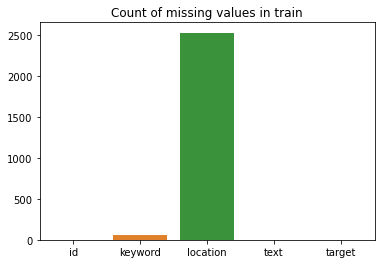

In [355]:
# count missing values
data = train.isna().sum()
ax = sns.barplot(x = data.index, y = data.values);
ax.set_title('Count of missing values in train');

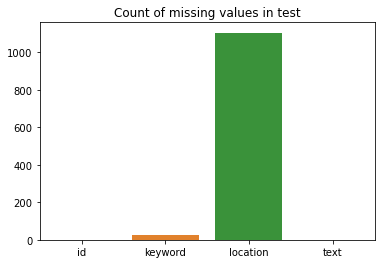

In [356]:
# count missing values
data = test.isna().sum()
ax = sns.barplot(x = data.index, y = data.values);
ax.set_title('Count of missing values in test');

### keyword column

In [357]:
test['keyword'].value_counts().shape

(221,)

In [358]:
train['keyword'].value_counts().shape

(221,)

In [359]:
# unique values
train_keywords = list(train['keyword'].value_counts().index.values)
test_keywords = list(test['keyword'].value_counts().index.values)

In [360]:
v = list(test['keyword'].value_counts().index.values)

In [361]:
# common unique values
common_keywords = set(train_keywords).intersection(test_keywords)

In [362]:
len(train_keywords), len(test_keywords), len(common_keywords)

(221, 221, 221)

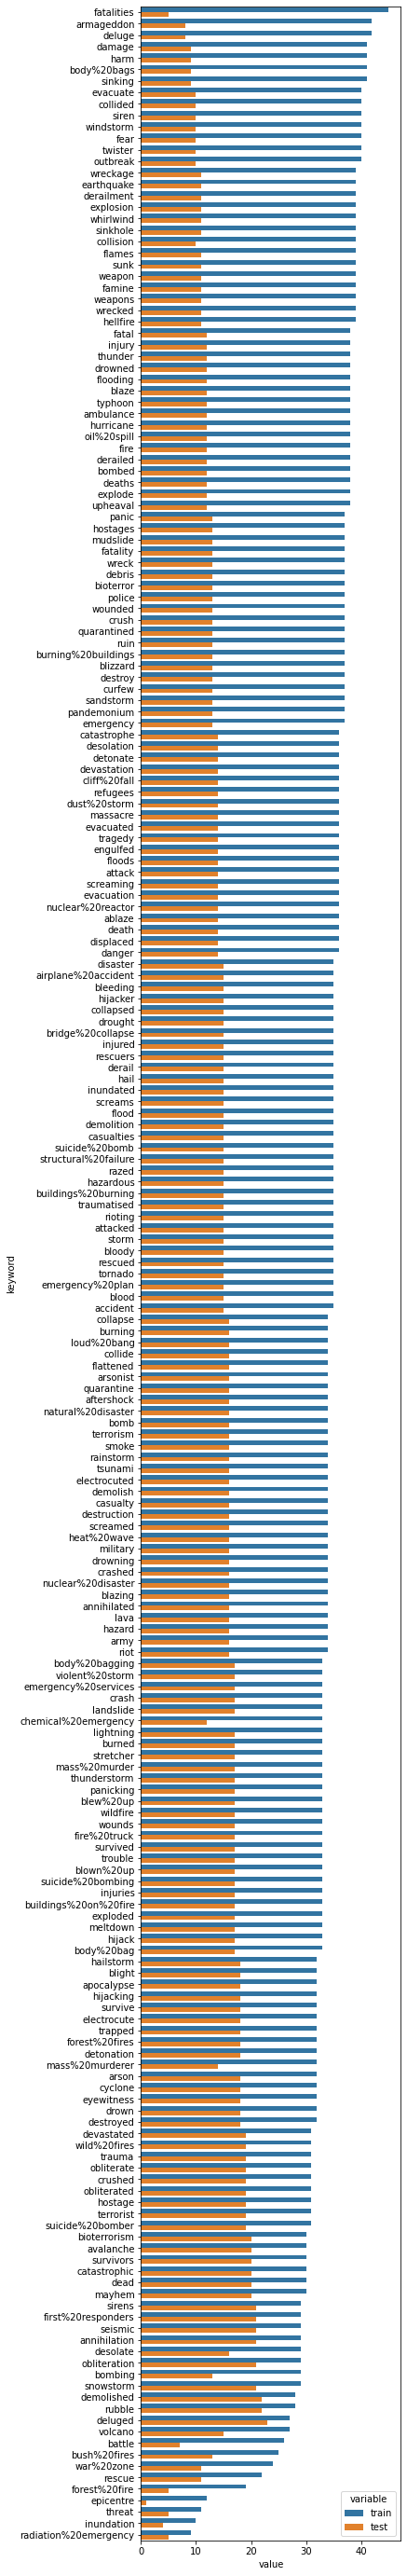

In [363]:
# plot
keywords_count = pd.concat([train['keyword'].value_counts(), test['keyword'].value_counts()], axis = 1).reset_index()
keywords_count.columns = ['keyword', 'train', 'test']
keywords_count = pd.melt(keywords_count, id_vars=['keyword'], value_vars=['train', 'test'])
plt.subplots(figsize=(5,50))
sns.barplot(x="value", y="keyword", hue="variable", data=keywords_count);


### Location column

In [364]:
# count unique values
train['location'].value_counts().shape

(3341,)

In [365]:
# Let's take a look at some of them.
train['location'].value_counts().index.values[:300]

array(['USA', 'New York', 'United States', 'London', 'Canada', 'Nigeria',
       'UK', 'Los Angeles, CA', 'India', 'Mumbai', 'Washington, DC',
       'Kenya', 'Worldwide', 'Australia', 'Chicago, IL', 'California',
       'New York, NY', 'Everywhere', 'California, USA', 'United Kingdom',
       'San Francisco', 'Florida', 'Washington, D.C.', 'Indonesia',
       'Los Angeles', 'Toronto', 'NYC', 'Ireland', 'Seattle', 'Earth',
       'Chicago', 'San Francisco, CA', 'Sacramento, CA', 'London, UK',
       'ss', 'New York City', 'London, England', 'Texas', 'Atlanta, GA',
       '304', 'San Diego, CA', 'Denver, Colorado', 'US', 'Dallas, TX',
       'Manchester', 'World', 'Nashville, TN', 'South Africa',
       'Houston, TX', 'Scotland', 'Seattle, WA', 'Pennsylvania, USA',
       'worldwide', 'Memphis, TN', 'Denver, CO', 'Austin, TX', 'Sydney',
       'Tennessee', 'California, United States',
       ' Road to the Billionaires Club', 'Brooklyn, NY', 'Orlando, FL',
       'Oklahoma City, OK', 'Mo

In [366]:
# minimum and maximum
train['location'].value_counts().describe()

count    3341.000000
mean        1.520503
std         3.022364
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       104.000000
Name: location, dtype: float64

In [367]:
# top frecuencies
train['location'].value_counts().sort_values(ascending = False)[:20]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
New York, NY        15
Everywhere          15
California, USA     15
Florida             14
Name: location, dtype: int64

In [368]:
# values that only appear once
np.sum(train['location'].value_counts() == 1)

2818

#### Obervation: location column

* About 50% of the train data has a missimg value in the location column
* The location column's values seem to be a placename or a placename followed by a comma and a country name.
* There are some very frecuent values while there 2818 unique values that appear only once in the train data

### Duplicated values

In [369]:
# duplicated text value
train.duplicated(subset = ['text']).sum()

110

In [370]:
# duplicated location and text value
train.duplicated(subset = ['location','text']).sum()

82

In [371]:
# duplicated keyword and text value
train.duplicated(subset = ['keyword','text']).sum()

87

In [372]:
#  duplicated keyword, location and text value
train.duplicated(subset = ['keyword', 'location','text']).sum()

61

In [373]:
# see the duplicated data
train[train.duplicated(subset = ['keyword', 'location','text'], keep = False)][-10:]

,id,keyword,location,text,target
6363,9095,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6377,9113,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6378,9114,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6434,9207,suicide%20bombing,NaN,'Suicide bombing at [location named]...' #prem...,1
6449,9225,suicide%20bombing,NaN,'Suicide bombing at [location named]...' #prem...,1
6652,9531,terrorist,MAD as Hell,RT AbbsWinston: #Zionist #Terrorist kidnapped ...,1
6656,9539,terrorist,MAD as Hell,RT AbbsWinston: #Zionist #Terrorist kidnapped ...,1


In this case, the same user tweets the same message many times.   
It would be better to keep only one row per a combination of keyword, location and message  
Also, %20 stands for a space in the ASCII encoding.

### Text

In [374]:
# take a look at some rows
train['text'][-30:].values

array(['Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/aaWZXykLES http://t.co/RsMvgDxRiv',
       'These boxes are ready to explode! Exploding Kittens finally arrived! gameofkittens #explodingkittens\x89Û_ https://t.co/TFGrAyuDC5',
       'Calgary Police Flood Road Closures in Calgary. http://t.co/RLN09WKe9g',
       '#Sismo DETECTADO #JapÌ_n 15:41:07 Seismic intensity 0 Iwate Miyagi JST #?? http://t.co/gMoUl9zQ2Q',
       'Sirens everywhere!',
       'BREAKING: #ISIS claims responsibility for mosque attack in Saudi Arabia that killed 13 http://t.co/VZ640XOSwj http://t.co/m2HpnOAK8b',
       'Omg earthquake',
       'SEVERE WEATHER BULLETIN No. 5 FOR: TYPHOON \x89ÛÏ#HannaPH\x89Û\x9d (SOUDELOR) TROPICAL CYCLONE: WARNING ISSUED AT 5:00 PM 06... http://t.co/tHhjJw51PE \x89Û_',
       'Heat wave warning aa? Ayyo dei. Just when I plan to visit friends after a year.',
       'An IS group suicide bomber detonated an explosives-packed vest in a

Some characteristics can be seen in the texts:
* hastag #
* emoticon (e.g., :) )
* colloquial expression (e.g., LOOOOOOL)

## Data Cleaning

### Strategy

* Use only the id, keyword, text and target columns. So, the location column will be excluded
* The id and target colums do not need to clean as they do not have any missing value
* For the keyword column, dummy columns will be created
* For the text column, all values are tokenized

In [375]:
# drop duplicated rows
# train.drop_duplicates(subset = ['keyword', 'location','text'], inplace = True)
train.drop_duplicates(subset = ['text'], inplace = True)

In [376]:
# concatenate the train and test dataframes
train['type'] = 'train'
test['type'] = 'test'

In [377]:
train.head()

,id,keyword,location,text,target,type
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,train
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,train
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,train
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,train
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,train


In [378]:
test.head()

,id,keyword,location,text,type
0,0,NaN,NaN,Just happened a terrible car crash,test
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",test
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",test
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,test
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,test


In [379]:
# concatenate the train and test dataframes
merged_df = pd.concat([train, test], ignore_index=True)
merged_df.isna().sum()

id             0
keyword       82
location    3587
text           0
target      3263
type           0
dtype: int64

In [380]:

merged_df.shape


(10766, 6)

### keyword

In [381]:
def create_keyword_dummy_df(df):
    '''create a keyword dummy dataframe'''
    keyword_df = df['keyword'].str.replace('%20', ' ')
    keyword_df.fillna('no keyword', inplace = True)
    # create a dummy df
    keyword_dummy_df = pd.get_dummies(keyword_df).reset_index(drop = True)
    keyword_dummy_colnames = list(keyword_dummy_df.columns.values)
    return keyword_dummy_df, keyword_dummy_colnames

In [382]:
def create_keyword_df(df):
    '''create a keyword dataframe'''
    keyword_df = df['keyword'].str.replace('%20', ' ')
    keyword_df.fillna('', inplace = True)
    return keyword_df

In [383]:
keyword_df = create_keyword_df(merged_df)
keyword_df.value_counts()

                       82
trouble                50
destruction            50
accident               50
obliteration           50
                       ..
forest fire            24
threat                 16
radiation emergency    14
inundation             14
epicentre              13
Name: keyword, Length: 222, dtype: int64

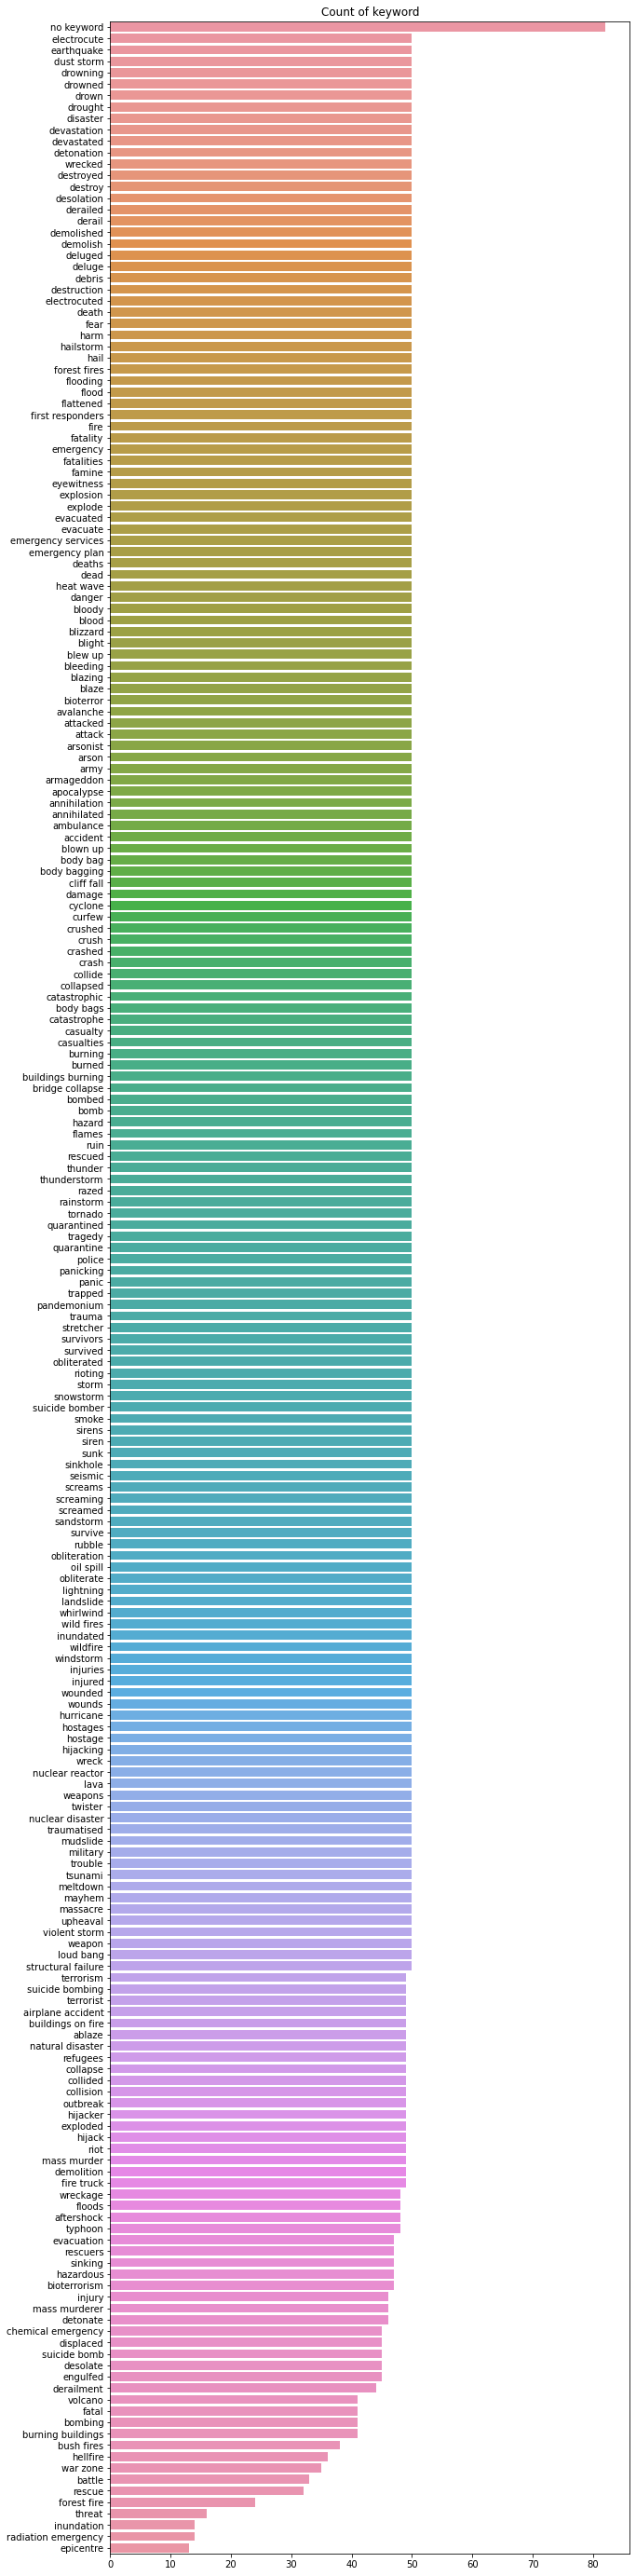

In [384]:
keyword_dummy_df, keyword_dummy_colnames = create_keyword_dummy_df(merged_df)
data = keyword_dummy_df.sum().sort_values(ascending = False)

plt.subplots(figsize=(10,50))
ax = sns.barplot(y = data.index, x = data.values);
ax.set_title('Count of keyword');

In [385]:
keyword_dummy_df.isna().sum().sum()

0

In [386]:
keyword_dummy_df.shape

(10766, 222)

### Text

To clean tweets:

* Remove unnecessary characters
* Tokenization 
* Remove stopwords
* Stemming

In [387]:
# define functions

def remove_url(text):
    '''remove URLs'''
    return re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def remove_number(text):
    '''remove numbers'''
    return re.sub(r'\d+', '', text)

def remove_twitter_char(text):
    '''remove hashtags and mentions'''
    text = re.sub(r"@[\w]*", '', text)
    text = re.sub(r"#[\w]*", '', text)
    return text

def remove_specific_char(text):
    '''remove specific characters'''
    return re.sub(r"\[\w]*", '', text)
    
def substitute_char(text):
    '''substitute specific characters by space'''
        
    # substitute hyphen with whitespace
    text = re.sub("-", " ", text)
    
    # substitute apostrophe with whitespace
    text = re.sub("'", " ", text)
    
     # substitute colon with whitespace
    text = re.sub(":", " ", text)
    
    return text

def remove_punctuation(text):
    '''remove punctuations and convert characters to lower case'''
    text = "".join([char for char in text if char not in string.punctuation]) 
    return text


def remove_doblespace(text):
    '''substitute multiple whitespace with single whitespace'''
    return re.sub('\s+', ' ', text).strip()


def clean_text(text):
    """
    This function cleans a text.
    :param text: a string
    :returns: a cleaned text
    """
    text = remove_url(text)
    text = remove_number(text)
    text = remove_twitter_char(text)
    text = remove_specific_char(text)
    text = substitute_char(text)
    text = remove_punctuation(text)
    text = remove_doblespace(text)
    
    return text
    

In [388]:
# define a function

def tokenize(text):
    """
    This function tokenizes a text.

    :param text: a text to tokenize
    :return: a list of tokens
    """
    tokenizer = TweetTokenizer(reduce_len=True)
    stemmer = PorterStemmer()
    stop_words = stopwords.words('english')
    
    tokens = tokenizer.tokenize(text)

    clean_tokens = []

    for tok in tokens:
        clean_tok = tok.lower().strip()
        if clean_tok not in stop_words:
            clean_tokens.append(stemmer.stem(clean_tok))
            
    # unique tokens
    clean_tokens = set(clean_tokens)
    
    return clean_tokens

In [389]:
# clean texts
text_df = merged_df['text'].apply(lambda x: clean_text(x)).to_frame()

In [390]:
text_df

,text
0,Our Deeds are the Reason of this May ALLAH For...
1,Forest fire near La Ronge Sask Canada
2,All residents asked to shelter in place are be...
3,people receive evacuation orders in California
4,Just got sent this photo from Ruby as smoke fr...
...,...
10761,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10762,Storm in RI worse than last hurricane My citya...
10763,Green Line derailment in Chicago
10764,MEG issues Hazardous Weather Outlook HWO


## Feature Engineering

In [457]:
# url counts
text_df['url count'] = merged_df['text'].apply(lambda x: len(re.findall(r'https?:\/\/.*[\r\n]*', x)))


In [458]:
# mention counts
text_df['mention count'] = merged_df['text'].apply(lambda x: len(re.findall(r"@[\w]*", x)))


In [459]:
# hashtag counts
text_df['hashtag count'] = merged_df['text'].apply(lambda x: len(re.findall(r"#[\w]*", x)))


In [460]:
# emoticon counts

In [461]:
# count letters
text_df['letter counts'] = text_df['text'].apply(lambda x: len(x))

In [462]:
# count words
text_df['word counts'] = text_df['text'].apply(lambda x: len(list(map(len, x.split()))))

In [463]:
# uppercase letters count
text_df['uppercase counts'] = text_df['text'].apply(lambda x: len(re.findall(r'[A-Z]',x)))

In [464]:
# lowercase letters count
text_df['lowercase counts'] = text_df['text'].apply(lambda x: len(re.findall(r'[a-z]',x)))

In [465]:
# save numeric colnames
numeric_colnames = text_df.select_dtypes(exclude=['object']).columns.values.tolist()
text_colnames = text_df.columns.values.tolist()
text_colnames, numeric_colnames

(['text',
  'letter counts',
  'word counts',
  'uppercase counts',
  'lowercase counts',
  'url count',
  'mention count',
  'hashtag count'],
 ['letter counts',
  'word counts',
  'uppercase counts',
  'lowercase counts',
  'url count',
  'mention count',
  'hashtag count'])

In [466]:
text_df.head()

,text,letter counts,word counts,uppercase counts,lowercase counts,url count,mention count,hashtag count
0,Our Deeds are the Reason of this May ALLAH For...,57,12,10,36,0,0,1
1,Forest fire near La Ronge Sask Canada,37,7,5,26,0,0,0
2,All residents asked to shelter in place are be...,130,22,2,107,0,0,0
3,people receive evacuation orders in California,46,6,1,40,0,0,1
4,Just got sent this photo from Ruby as smoke fr...,68,14,2,53,0,0,2


## Data Preparation

Cancatenate dataframes
* 

In [467]:
transformed_df = pd.concat([merged_df.drop(columns = ['keyword', 'location', 'text']), keyword_dummy_df, text_df], axis = 1)
transformed_df.head()

,id,target,type,ablaze,accident,aftershock,airplane accident,ambulance,annihilated,annihilation,...,wreckage,wrecked,text,letter counts,word counts,uppercase counts,lowercase counts,url count,mention count,hashtag count
0,1,1.0,train,0,0,0,0,0,0,0,...,0,0,Our Deeds are the Reason of this May ALLAH For...,57,12,10,36,0,0,1
1,4,1.0,train,0,0,0,0,0,0,0,...,0,0,Forest fire near La Ronge Sask Canada,37,7,5,26,0,0,0
2,5,1.0,train,0,0,0,0,0,0,0,...,0,0,All residents asked to shelter in place are be...,130,22,2,107,0,0,0
3,6,1.0,train,0,0,0,0,0,0,0,...,0,0,people receive evacuation orders in California,46,6,1,40,0,0,1
4,7,1.0,train,0,0,0,0,0,0,0,...,0,0,Just got sent this photo from Ruby as smoke fr...,68,14,2,53,0,0,2


In [468]:
# check missing values
transformed_df.isna().sum()

id                     0
target              3263
type                   0
ablaze                 0
accident               0
                    ... 
uppercase counts       0
lowercase counts       0
url count              0
mention count          0
hashtag count          0
Length: 233, dtype: int64

### Train and test

In [469]:
new_train = transformed_df[transformed_df['type'] == 'train'].drop(columns = ['type'])
new_test = transformed_df[transformed_df['type'] == 'test'].drop(columns = ['type'])

In [470]:
# check shapes
new_train.shape[0] == train.shape[0], new_test.shape[0] == test.shape[0]

(True, True)

In [471]:
new_train.head()

,id,target,ablaze,accident,aftershock,airplane accident,ambulance,annihilated,annihilation,apocalypse,...,wreckage,wrecked,text,letter counts,word counts,uppercase counts,lowercase counts,url count,mention count,hashtag count
0,1,1.0,0,0,0,0,0,0,0,0,...,0,0,Our Deeds are the Reason of this May ALLAH For...,57,12,10,36,0,0,1
1,4,1.0,0,0,0,0,0,0,0,0,...,0,0,Forest fire near La Ronge Sask Canada,37,7,5,26,0,0,0
2,5,1.0,0,0,0,0,0,0,0,0,...,0,0,All residents asked to shelter in place are be...,130,22,2,107,0,0,0
3,6,1.0,0,0,0,0,0,0,0,0,...,0,0,people receive evacuation orders in California,46,6,1,40,0,0,1
4,7,1.0,0,0,0,0,0,0,0,0,...,0,0,Just got sent this photo from Ruby as smoke fr...,68,14,2,53,0,0,2


In [472]:
new_test.head()

,id,target,ablaze,accident,aftershock,airplane accident,ambulance,annihilated,annihilation,apocalypse,...,wreckage,wrecked,text,letter counts,word counts,uppercase counts,lowercase counts,url count,mention count,hashtag count
7503,0,NaN,0,0,0,0,0,0,0,0,...,0,0,Just happened a terrible car crash,34,6,1,28,0,0,0
7504,2,NaN,0,0,0,0,0,0,0,0,...,0,0,Heard about is different cities stay safe ever...,50,8,1,42,0,0,1
7505,3,NaN,0,0,0,0,0,0,0,0,...,0,0,there is a forest fire at spot pond geese are ...,94,19,1,75,0,0,0
7506,9,NaN,0,0,0,0,0,0,0,0,...,0,0,Apocalypse lighting,19,2,1,17,0,0,2
7507,11,NaN,0,0,0,0,0,0,0,0,...,0,0,Typhoon Soudelor kills in China and Taiwan,42,7,4,32,0,0,0


In [473]:
# create train and test
X_train = new_train.drop(columns = ['id', 'target'])
y_train = new_train['target']

X_test = new_test.drop(columns = ['id', 'target'])

test_ids = new_test['id']

In [474]:
X_test.head()

,ablaze,accident,aftershock,airplane accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,...,wreckage,wrecked,text,letter counts,word counts,uppercase counts,lowercase counts,url count,mention count,hashtag count
7503,0,0,0,0,0,0,0,0,0,0,...,0,0,Just happened a terrible car crash,34,6,1,28,0,0,0
7504,0,0,0,0,0,0,0,0,0,0,...,0,0,Heard about is different cities stay safe ever...,50,8,1,42,0,0,1
7505,0,0,0,0,0,0,0,0,0,0,...,0,0,there is a forest fire at spot pond geese are ...,94,19,1,75,0,0,0
7506,0,0,0,0,0,0,0,0,0,0,...,0,0,Apocalypse lighting,19,2,1,17,0,0,2
7507,0,0,0,0,0,0,0,0,0,0,...,0,0,Typhoon Soudelor kills in China and Taiwan,42,7,4,32,0,0,0


In [475]:
# create train and validation 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=99)

In [476]:
X_train.columns.values

array(['ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desolate',

## Modeling

### Logistic 

In [526]:
# define a model

def build_model():
    """
    This function builds a model.
    """
    
    get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
    get_category_data = FunctionTransformer(lambda x: x.drop(columns = text_colnames), validate=False)
    get_numeric_data = FunctionTransformer(lambda x: x[numeric_colnames], validate=False)

    
    pipeline = Pipeline([
        
        ('features', FeatureUnion([
            
            ('category', Pipeline([
                ('selector', get_category_data),
            ])),
            
            ('numeric', Pipeline([
                ('selector', get_numeric_data),
                ('scale', MinMaxScaler())
            ])),
        
            ('text', Pipeline([
                ('selector', get_text_data),
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
            ])),
            
        ])),
        
#          ('clf',SVC()),  
#         ('clf', SGDClassifier(max_iter=1000, tol=1e-3)),  
#          ('clf', RandomForestClassifier(max_depth=2, random_state=99)), 
         ('clf',  MultinomialNB()), 
       
        
    ])

    parameters = {
        'features__text__vect__ngram_range': ((1, 1), (1, 2)),
        'features__text__vect__max_df': (0.5, 0.7, 1.0),
#         'clf__kernel': ('poly', 'rbf', 'sigmoid'),
#         'clf__C': [1, 10],
        'features__transformer_weights': (
            {'category': 0.5, 'numeric': 0.8, 'text': 1},
            {'category': 0.8, 'numeric': 0.5, 'text': 1},
            {'category': 0.5, 'numeric': 0.5, 'text': 1},

        )
    }

    cv = GridSearchCV(pipeline,
                      param_grid=parameters,
                      scoring='f1_macro',
                      refit='f1_macro',
                      return_train_score=True,
                      verbose = 10,
#                       cv = 10,
                      n_jobs=-1 )
    
    return cv

In [527]:
model = build_model()

In [528]:
model.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__features', 'estimator__clf', 'estimator__features__n_jobs', 'estimator__features__transformer_list', 'estimator__features__transformer_weights', 'estimator__features__verbose', 'estimator__features__category', 'estimator__features__numeric', 'estimator__features__text', 'estimator__features__category__memory', 'estimator__features__category__steps', 'estimator__features__category__verbose', 'estimator__features__category__selector', 'estimator__features__category__selector__accept_sparse', 'estimator__features__category__selector__check_inverse', 'estimator__features__category__selector__func', 'estimator__features__category__selector__inv_kw_args', 'estimator__features__category__selector__inverse_func', 'estimator__features__category__selector__kw_args', 'estimator__features__category__selector__validate', 'estimator__features__numeric__memory', 'estimator__features__numeric__st

In [529]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('category',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         FunctionTransformer(accept_sparse=False,
                                                                                                             check_inverse=True,
                                                                                                             func=<function build_model.<locals>.<lambda> at 0x7fa1b3f6bd40>,
                                                                                      

In [530]:
y_pred = model.predict(X_val)

In [531]:
precision_recall_fscore_support(np.array(y_val), y_pred, average='macro')

(0.8101347364615521, 0.7937985654512851, 0.7986368965535051, None)

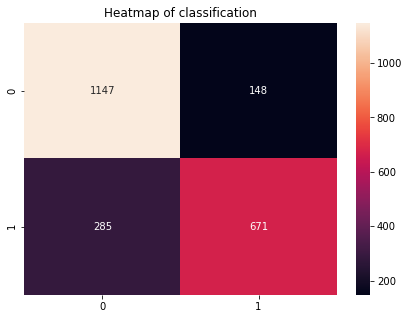

In [532]:
# confusion matrix
cm = confusion_matrix(np.array(y_val), y_pred);
plt.subplots(figsize=(7, 5))
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Heatmap of classification');

In [533]:
model.cv_results_

{'mean_fit_time': array([4.46056213, 4.94393382, 4.63690343, 4.41485014, 4.59381251,
        0.01957502, 0.01796312, 0.0184514 , 0.01706271, 0.01735773,
        4.59056077, 4.6144917 , 4.48414845, 4.40811744, 4.43728919,
        0.01706071, 0.02034492, 0.02049751, 0.01882782, 0.0201776 ,
        4.61275306, 4.48287263, 4.44686651, 4.42330256, 4.31457019,
        0.01864691, 0.02431927, 0.01856241, 0.01927185, 0.01794291]),
 'std_fit_time': array([8.39470245e-02, 1.89432768e-01, 2.77022877e-01, 3.45710560e-02,
        6.62786339e-02, 2.37497249e-03, 9.25370421e-04, 2.12038262e-03,
        8.90882092e-04, 1.15326630e-03, 2.57331791e-01, 1.42772817e-01,
        7.31201711e-02, 3.69370316e-02, 4.31117610e-02, 4.44759501e-04,
        4.06684027e-03, 2.16472106e-03, 1.84504196e-03, 4.47285945e-03,
        1.99224232e-01, 1.27836190e-01, 4.15955803e-02, 2.82645847e-02,
        3.20779350e-01, 6.94039676e-04, 8.37746203e-03, 9.48912494e-04,
        1.16717121e-03, 2.31042095e-04]),
 'mean_scor

In [534]:
model.best_params_

{'features__text__vect__max_df': 0.5,
 'features__text__vect__ngram_range': (1, 1),
 'features__transformer_weights': {'category': 0.5, 'numeric': 0.5, 'text': 1}}

## Submission

In [506]:
X_test.shape

(3263, 230)

In [507]:
y_submission = model.predict(X_test)

In [508]:
np.array(test_ids)

array([    0,     2,     3, ..., 10868, 10874, 10875])

In [509]:
data = {'id': np.array(test_ids), 'target': y_submission.astype(int)}
data

{'id': array([    0,     2,     3, ..., 10868, 10874, 10875]),
 'target': array([1, 0, 1, ..., 1, 1, 0])}

In [510]:
submission_df = pd.DataFrame(data = data)

In [511]:
submission_df.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [512]:
submission_df.shape

(3263, 2)

In [513]:
submission_df.to_csv('submission.csv', index=False)
print('submission.csv created')

submission.csv created
